## Spam Classifier in Spark

I am using the data that is available publicly on Kaggle. The link is: https://www.kaggle.com/uciml/sms-spam-collection-dataset

I built this code on Databricks Community edition. If you dont have an account, create one by visiting to https://community.cloud.databricks.com/login.html.

Following are the steps to set the environment on databricks community edition.

### 1. Spinup the cluster

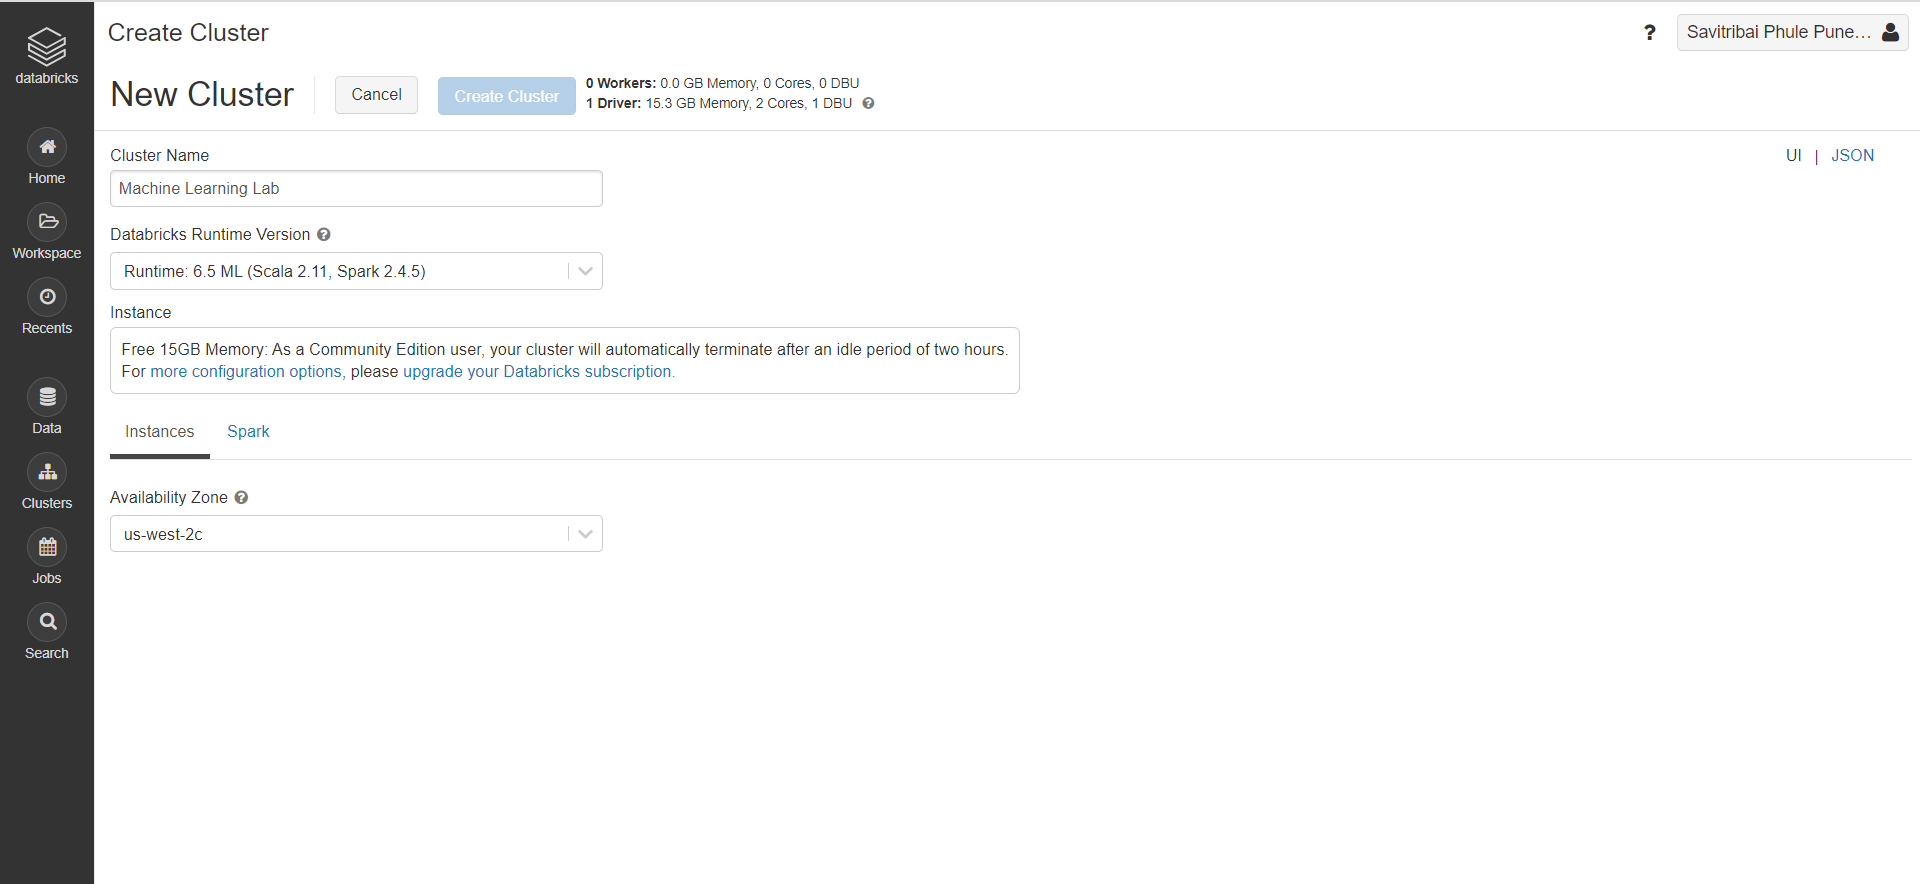

### 2. Upload the data

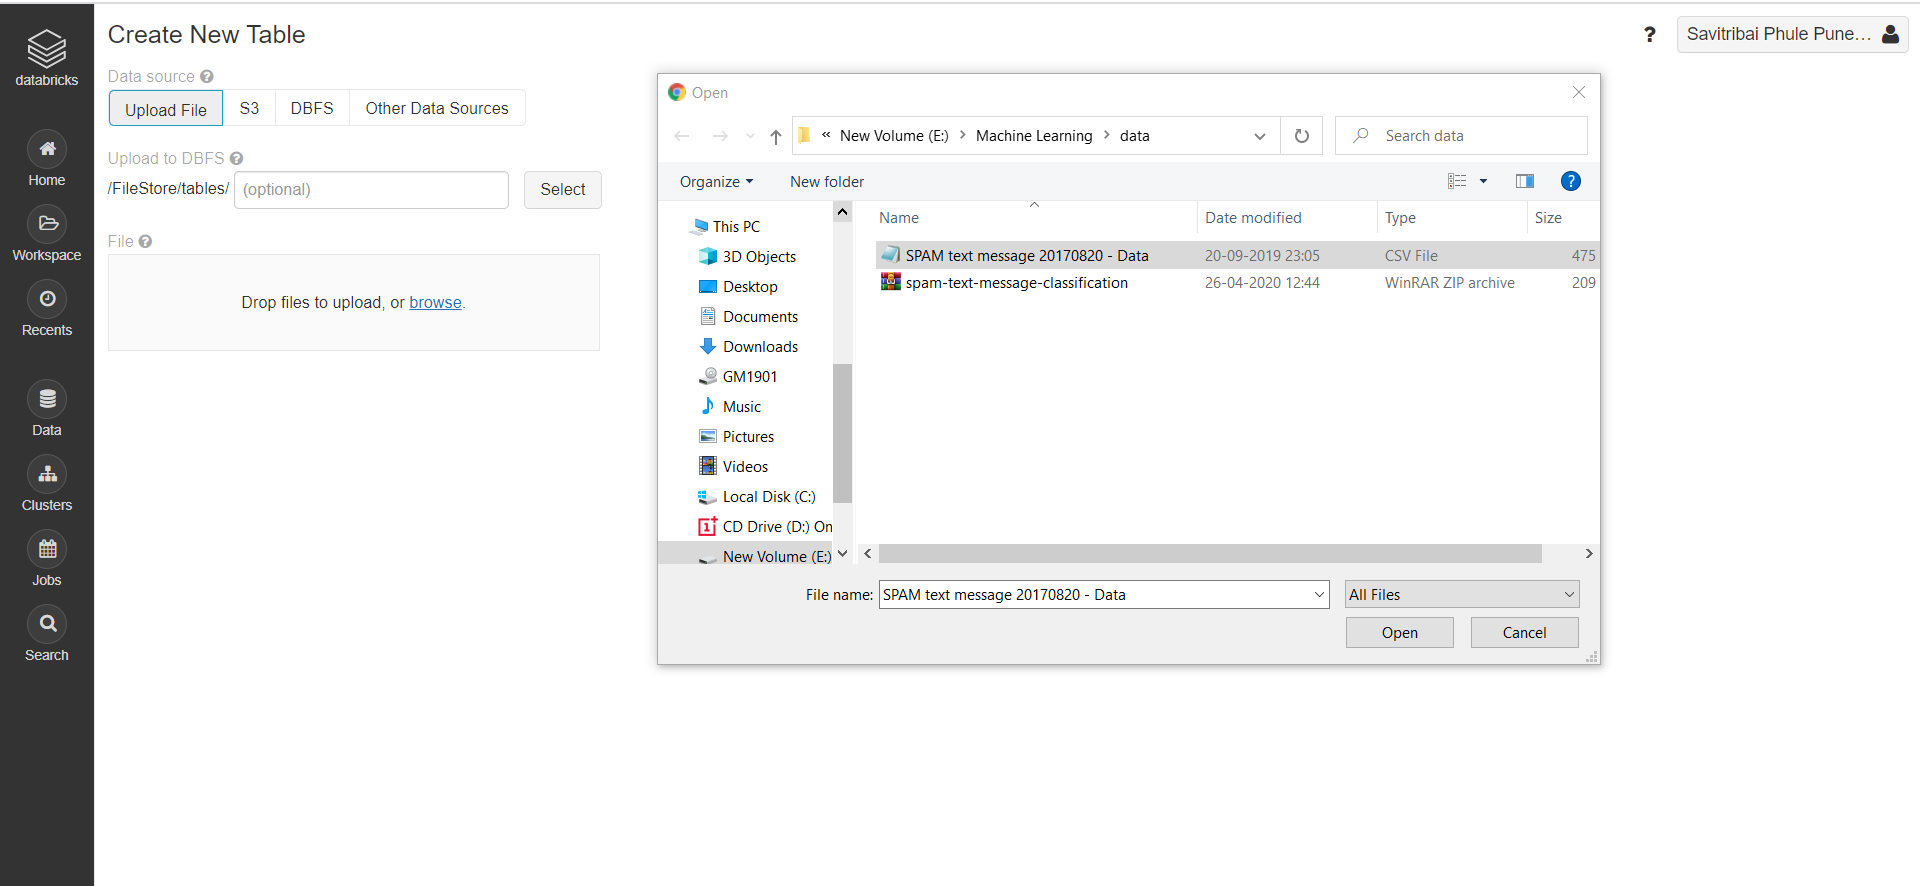

### Create a Table in Notebook

Click on Create Table in Notebook

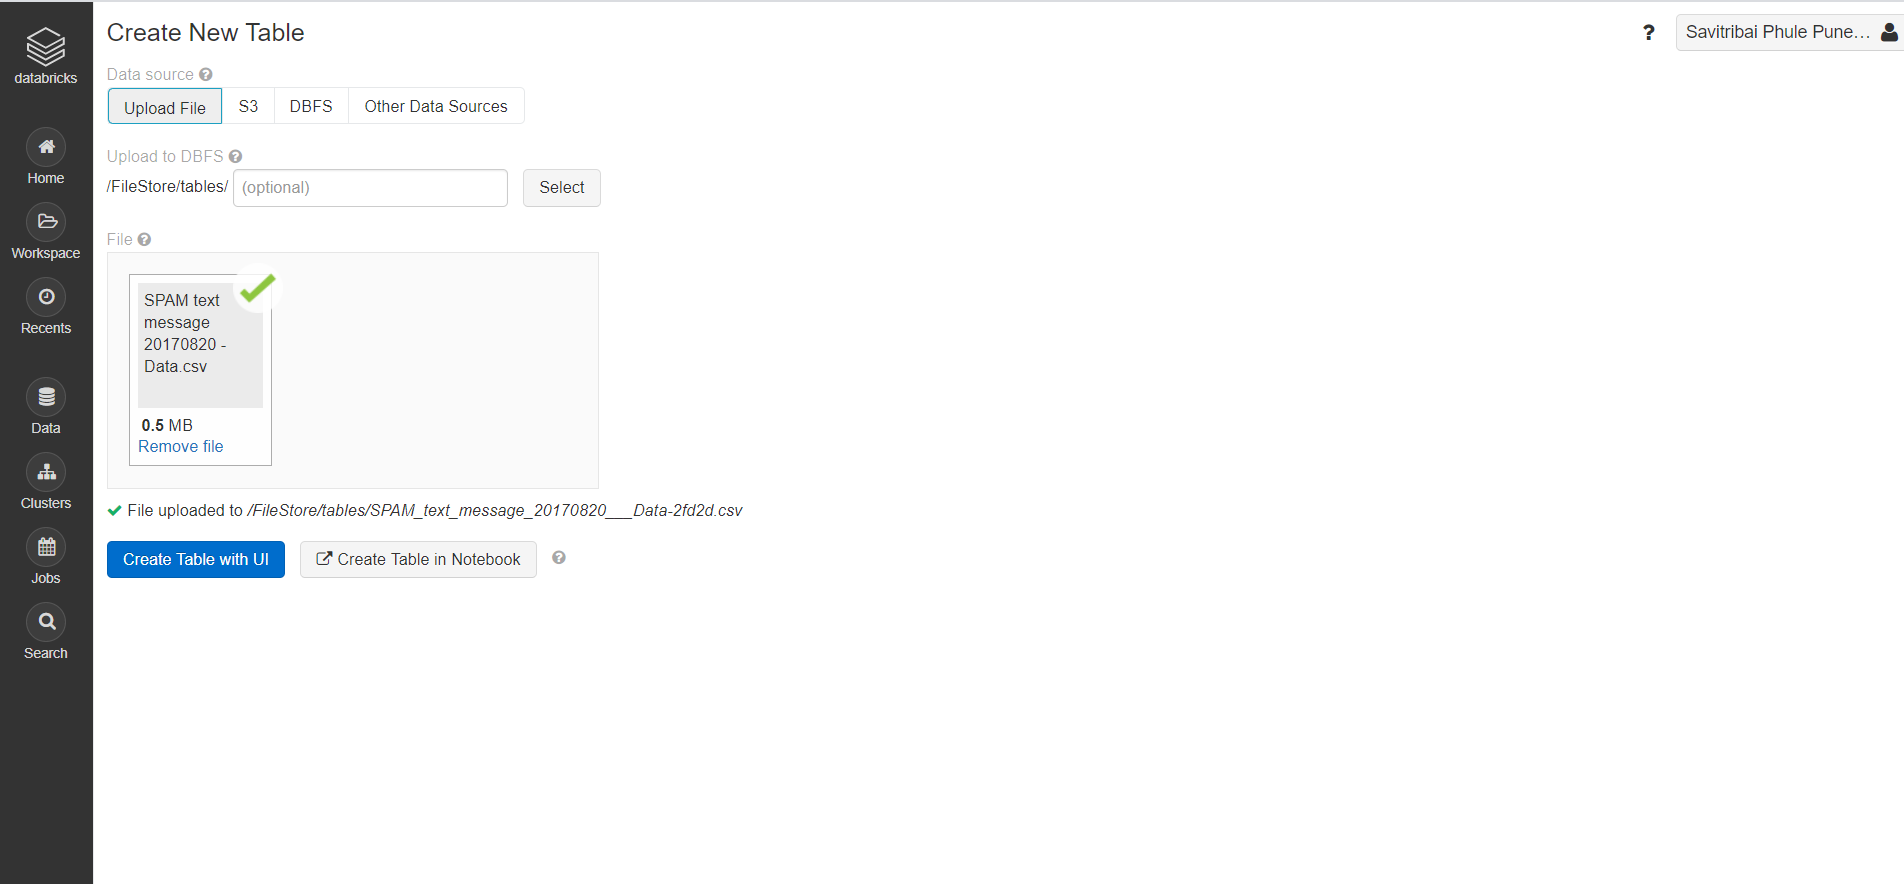

## Spam Classification using RandomForest Algorithm

In [ ]:
# File location and type
file_location = "/FileStore/tables/SPAM_text_message_20170820___Data-2fd2d.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

display(df)

In [2]:
# Lets check the count of the data
df.count()

# Thats good amount of data we have to train the model. Before training the model, let's do some basic preprocessing w.r.t textual data.

## Preprocessing Step 1 : Tokenizing the email content.

In [3]:

# We initialize the tokenizer first and then create a model and then transform the data.
from pyspark.ml.feature import Tokenizer
tokenizer = Tokenizer(inputCol="Message", outputCol="tokens")

tokenized_df =  tokenizer.transform(df)


# Lets see the first row of new df
tokenized_df.take(1)

## Preprocessing Step 2 : Removing Stopwords

In [4]:

# We follow the same process again, build stopwords model and transform the tokenized df.
from pyspark.ml.feature import StopWordsRemover

stop_word_remover =  StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
filtered_df = stop_word_remover.transform(tokenized_df)


# Let's check the data. We will set truncate to false.

filtered_df.show(1,truncate=False)

## Preprocessing Step 3 : Removing Garbage tokens

In [5]:
# As we can see we have some garbage data like tokens having length =1 & 2. So lets filter such tokens using lamba expressions

# Register a udf
from pyspark.sql.functions import udf
from pyspark.sql.types import *

def filter_tokens(filtered_tokens):
  final_list=[]
  for token in filtered_tokens:
    if len(token)>=3:
      final_list.append(token)
  return final_list

filter_token_udf = udf(filter_tokens,ArrayType(StringType()))


In [6]:
# Create a new column using the created UDF

final_filtered_df = filtered_df.withColumn("final_filtered_tokens",filter_token_udf("filtered_tokens"))

final_filtered_df.show(1,truncate=False)

### Select the required columns only.

In [7]:
# Before we proceed, let select the columns that we need and create a new dataframe
new_DF = final_filtered_df.select("Category","Message","final_filtered_tokens")


## Preprocessing Step 4 : Remove special characters from tokens

In [8]:
# From the above cell, we can observe that We need to remove special characters from each tokens.


#We will use the UDF to build our custom function in python.
#Note that all these UDF are built using inbuilt python methods and you do not need any special libraries to be installed.

def remove_special_chars(final_filtered_tokens):
  final_token_list=[]
  for token in final_filtered_tokens:
    alphanumeric = [character for character in token if character.isalnum()]
    alphanumeric = "".join(alphanumeric)
    final_token_list.append(alphanumeric)
  
  return final_token_list
    

# Register the above function as UDF
remove_special_char_udf = udf(remove_special_chars,ArrayType(StringType()))

# Apply this UDF to final_filtered_tokens column

new_DF = new_DF.withColumn("cleaned_tokens",remove_special_char_udf("final_filtered_tokens"))

new_DF.show(10,truncate=False)

## Feature Extraction using TF-IDF

In [10]:
# Now that our data is some what clean, we can go ahead an computer vectors for the tokens. We will use TF-IDF and to implement this, we have 2 classes viz. HashingTF and IDF.
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

# Term frequency
hashingTF = HashingTF(inputCol="cleaned_tokens", outputCol="rawFeatures", numFeatures=20)
featurized_data = hashingTF.transform(new_DF)

# Inverse document frequency
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurized_data)
rescaled_data = idfModel.transform(featurized_data)

## Create Train-Test split

In [11]:
# Splittig data into train test splits.
splits = rescaled_data.randomSplit([0.7,0.3],1)

train_data = splits[0]

test_data = splits[1]



In [12]:
# train count
train_data.count()

In [13]:
# test count
test_data.count()

## Train the Model

In [14]:
# Now that everything is set, we can train our classification Model. I am planning to use RandomForest classifier but will also experiment with Multilayer Perceptron Classifier. We will use Pipeline to train our model.

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer

# to convert string categories to integer type.
labelIndexer = StringIndexer(inputCol="Category", outputCol="categoryIndex").fit(rescaled_data)

# create a random forest classsifier object.
rf = RandomForestClassifier(labelCol="categoryIndex", featuresCol="features", numTrees=30)

# covert the integers back to category strings.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",labels=labelIndexer.labels)


pipeline = Pipeline(stages=[labelIndexer, rf, labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(train_data)

# Make predictions.
predictions = model.transform(test_data)

## Evaluate the Model.

In [ ]:
# evaluate the trained model.

evaluator = MulticlassClassificationEvaluator(
    labelCol="categoryIndex", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % (accuracy))
print("Test Error = %g" % (1.0 - accuracy))